**Geliştirme Ortamı**

In [1]:
from fastai import __version__ as fastai_ver
from fastai.vision.all import *
import torch, os, numpy as np, matplotlib.pyplot as plt

print("fastai:", fastai_ver)
print("torch:", torch.__version__)
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

BASE = "/kaggle/input/intel-image-classification"
TRAIN_DIR = f"{BASE}/seg_train/seg_train"
TEST_DIR  = f"{BASE}/seg_test/seg_test"
IMG_SIZE  = 224
SEED      = 42
set_seed(SEED, reproducible=True)

print("Sınıf klasörleri:", os.listdir(TRAIN_DIR))

fastai: 2.7.19
torch: 2.6.0+cu124
GPU: Tesla P100-PCIE-16GB
Sınıf klasörleri: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']


**Veri Yükleme ve Keşif**

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'] -> 6


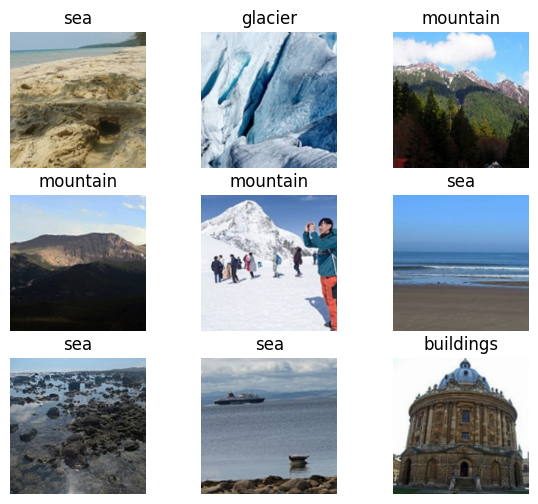

In [2]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=SEED),
    get_y=parent_label,
    item_tfms=Resize(IMG_SIZE),
    batch_tfms=aug_transforms(do_flip=True, flip_vert=False,
                              max_rotate=8, max_zoom=1.1, max_warp=0.,
                              max_lighting=0.2)
)
dls = dblock.dataloaders(TRAIN_DIR, bs=32, num_workers=4)
dls.show_batch(max_n=9, figsize=(7,6))
print("Classes:", dls.vocab, "->", len(dls.vocab))

In [3]:
from collections import Counter
counts = Counter([p.parent.name for p in get_image_files(TRAIN_DIR)])
pd.DataFrame(sorted(counts.items()), columns=["class", "count"])

,class,count
0,buildings,2191
1,forest,2271
2,glacier,2404
3,mountain,2512
4,sea,2274
5,street,2382


**Model Kurulumu (ResNet18 + Transfer Learning)**

In [4]:
metrics = [accuracy]
learn = vision_learner(
    dls, resnet18, metrics=metrics,
    cbs=[SaveModelCallback(monitor='accuracy', fname='best-resnet18')],
    path=Path('/kaggle/working'), model_dir=Path('/kaggle/working')
).to_fp32()
learn

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s] 


**Öğrenme Oranı & Eğitim**

lr_min: 0.010000000149011612 | lr_steep: 0.0014454397605732083


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

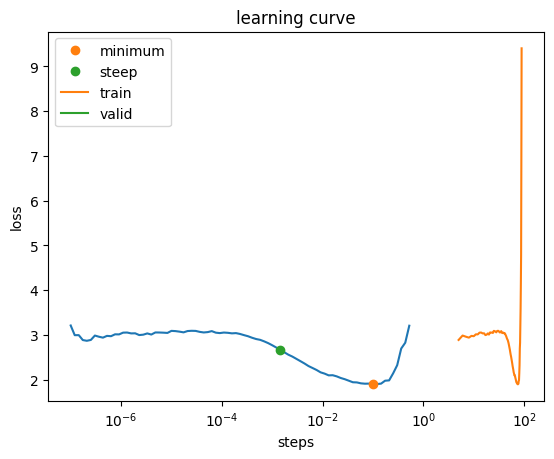

In [5]:
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
print("lr_min:", lr_min, "| lr_steep:", lr_steep)
learn.recorder.plot_loss()

In [6]:
learn.fit_one_cycle(12, slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.471463,0.315198,0.903065,00:28
1,0.462105,0.306503,0.903778,00:26
2,0.385575,0.250248,0.913756,00:26
3,0.340278,0.302542,0.894868,00:27
4,0.282899,0.199831,0.933713,00:26
5,0.247773,0.217980,0.930150,00:26
6,0.229612,0.190918,0.930862,00:27
7,0.211162,0.178005,0.937990,00:26
8,0.183351,0.173067,0.944048,00:26
9,0.166025,0.164791,0.946187,00:26


Better model found at epoch 0 with accuracy value: 0.9030648469924927.
Better model found at epoch 1 with accuracy value: 0.9037775993347168.
Better model found at epoch 2 with accuracy value: 0.913756251335144.
Better model found at epoch 4 with accuracy value: 0.9337134957313538.
Better model found at epoch 7 with accuracy value: 0.9379900097846985.
Better model found at epoch 8 with accuracy value: 0.9440484642982483.
Better model found at epoch 9 with accuracy value: 0.9461867213249207.
Better model found at epoch 10 with accuracy value: 0.9476122856140137.


In [7]:
learn.unfreeze()
fine_hist = learn.fit_one_cycle(5, slice(1e-5, 1e-4))
learn.export(Path("/kaggle/working/export.pkl"))
learn.save("resnet18-intel-best")
print("Kaydedildi: export.pkl & resnet18-intel-best.pth")

epoch,train_loss,valid_loss,accuracy,time
0,0.173573,0.168989,0.944405,00:32
1,0.171364,0.321841,0.941197,00:32
2,0.143716,0.162410,0.946187,00:32
3,0.104155,0.158925,0.947612,00:32
4,0.100890,0.158832,0.947612,00:32


Better model found at epoch 0 with accuracy value: 0.9444048404693604.
Better model found at epoch 2 with accuracy value: 0.9461867213249207.
Better model found at epoch 3 with accuracy value: 0.9476122856140137.
Kaydedildi: export.pkl & resnet18-intel-best.pth


**Eğitim Grafikleri**

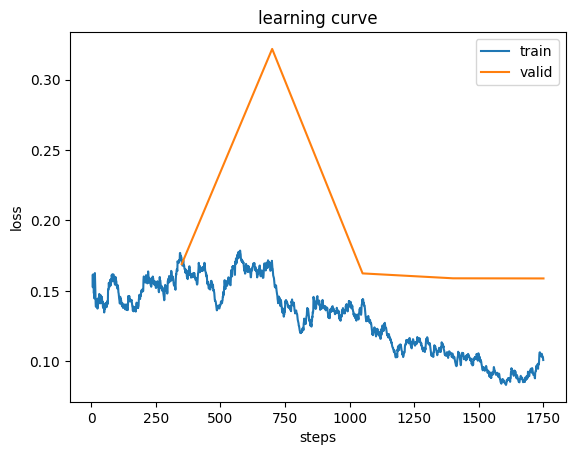

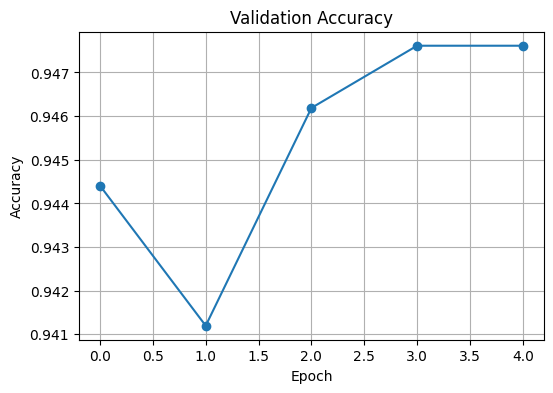

In [8]:
# Loss grafiği
learn.recorder.plot_loss()

# Accuracy eğrisi
hist = learn.recorder.values  # her epoch [train_loss, valid_loss, accuracy]
accs = [v[2] for v in hist]
plt.figure(figsize=(6,4))
plt.plot(accs, marker='o'); plt.title("Validation Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.grid(True); plt.show()

**Valid Değerlendirme: Confusion Matrix & Top Losses**

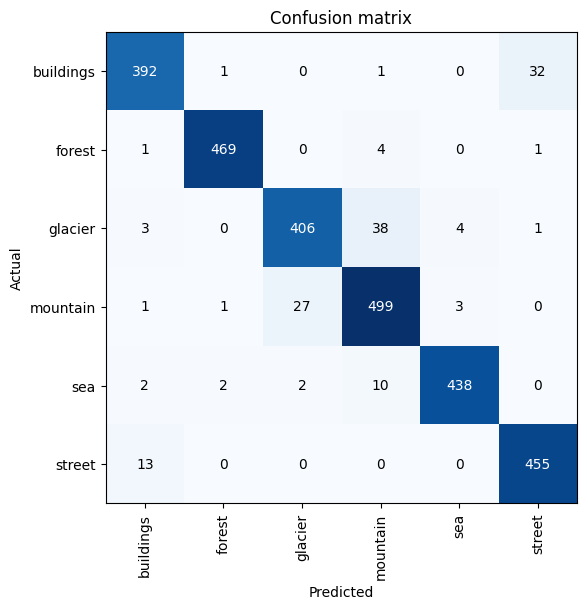

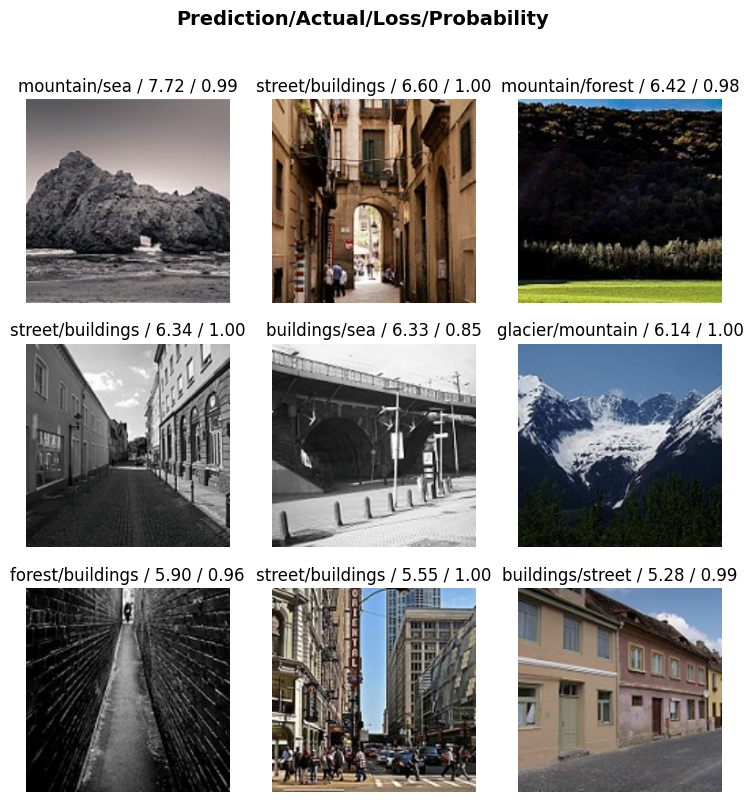

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))
interp.plot_top_losses(9, nrows=3, figsize=(9,9))

**Test Seti Performansı**

In [10]:
test_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label, splitter=IndexSplitter([]),
    item_tfms=Resize(IMG_SIZE)
)
test_dls = test_dblock.dataloaders(f"{BASE}/seg_test/seg_test", bs=32)
preds, targs = learn.get_preds(dl=test_dls.train)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_true = targs.cpu().numpy()
y_pred = preds.argmax(1).cpu().numpy()
print("Test Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=test_dls.vocab))

Test Accuracy: 0.87
              precision    recall  f1-score   support

   buildings       0.84      0.95      0.89       437
      forest       0.98      0.95      0.96       474
     glacier       0.82      0.74      0.78       553
    mountain       0.75      0.88      0.81       525
         sea       0.92      0.89      0.91       510
      street       0.96      0.84      0.89       501

    accuracy                           0.87      3000
   macro avg       0.88      0.87      0.87      3000
weighted avg       0.88      0.87      0.87      3000



**Grad-CAM Görselleştirme**

In [17]:
# === Minimal Grad-CAM (fastai v2 + ResNet18) ===
import torch.nn as nn, torch.nn.functional as F
import numpy as np, matplotlib.pyplot as plt
from PIL import Image

IMG_SIZE = 224  # senin kullandığın boyut

# 1) Gövdedeki (body) son Conv2d katmanı bul
def _last_conv_in_body(learn):
    body = learn.model[0]
    last = None
    for m in body.modules():
        if isinstance(m, nn.Conv2d): last = m
    return last

_target = _last_conv_in_body(learn)
acts = grads = None

def _fwd(_, __, out):  # forward activations
    global acts; acts = out.detach()
def _bwd(_, __, gout):  # backward grads
    global grads; grads = gout[0].detach()

# güvenli hook kur
try: h1.remove(); h2.remove()
except: pass
h1 = _target.register_forward_hook(_fwd)
h2 = _target.register_full_backward_hook(_bwd)

def gradcam(img_path, alpha=0.45):
    # 2) Taban görseli HER ZAMAN 224x224 yap (broadcast sorunu biter)
    base = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    base_np = np.asarray(base).astype(np.float32) / 255.0  # (224,224,3)

    # 3) Tensörü test_dl ile al, cihaza taşı
    dl = learn.dls.test_dl([PILImage.create(img_path)])
    x = dl.one_batch()
    if isinstance(x, (list, tuple)): x = x[0]
    x = x.to(learn.dls.device).requires_grad_(True)

    # 4) İleri & geri
    learn.model.eval(); learn.model.zero_grad()
    out = learn.model(x)                           # logits
    idx = out.argmax(1).item()
    out[0, idx].backward()

    # 5) CAM -> upsample -> [0,1]
    w   = grads.mean(dim=(2,3), keepdim=True)      # (C,1,1)
    cam = (w * acts).sum(dim=1, keepdim=True)      # (1,1,h,w)
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)[0,0]
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    cam = cam.cpu().numpy()                        # (224,224)

    # 6) Overlay
    heat = plt.cm.jet(cam)[...,:3]                 # (224,224,3)
    overlay = np.clip(alpha*heat + (1-alpha)*base_np, 0, 1)

    # 7) Gör
    pred_lbl = learn.dls.vocab[idx]
    conf = float(torch.softmax(out, dim=1)[0, idx])
    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.imshow(base_np); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(cam, cmap='jet'); plt.title("Grad-CAM"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title(f"Overlay\n{pred_lbl} ({conf:.2f})"); plt.axis("off")
    plt.tight_layout()

# örnek:
# gradcam(get_image_files(f"{BASE}/seg_test/seg_test/forest")[0])


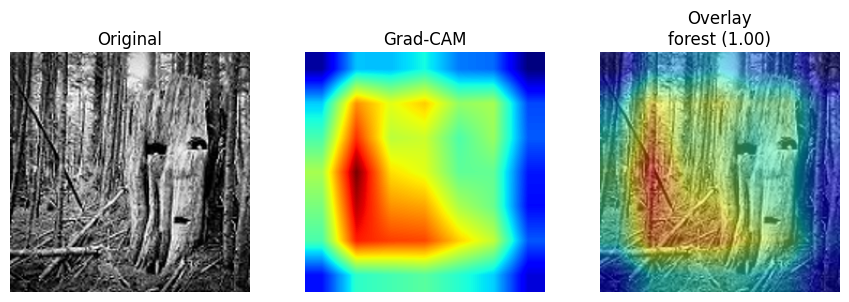

Saved -> /kaggle/working/gradcam_example.png


In [19]:
from pathlib import Path

img_path = get_image_files(f"{BASE}/seg_test/seg_test/forest")[0]  # örnek
gradcam(img_path, alpha=0.45)        
plt.savefig("/kaggle/working/gradcam_example.png", bbox_inches="tight", dpi=150)
plt.show()
print("Saved -> /kaggle/working/gradcam_example.png")


**Hiperparametre Denemesi (HPO mini-grid)**

In [18]:
def run_trial(lr_slice, wd=1e-2, epochs=3):
    # aynı dls ile yeni learner oluştur
    trial = vision_learner(
        dls, resnet18, metrics=[accuracy],
        wd=wd, path=Path('/kaggle/working'),
        cbs=[SaveModelCallback(monitor='accuracy', fname='tmp-best')]
    ).to_fp32()
    trial.fit_one_cycle(epochs, lr_slice)
    best = max([v[2] for v in trial.recorder.values])
    return best

grid = [
    (slice(1e-3, 1e-2), 1e-2),
    (slice(5e-4, 5e-3), 1e-2),
    (slice(1e-4, 1e-3), 1e-3),
]
results = []
for lr_slice, wd in grid:
    acc = run_trial(lr_slice, wd, epochs=3)
    results.append({"lr_slice": str(lr_slice), "wd": wd, "val_acc": float(acc)})
pd.DataFrame(results)


epoch,train_loss,valid_loss,accuracy,time
0,0.604139,0.335392,0.906985,00:28
1,0.343487,0.247748,0.910549,00:28
2,0.223599,0.190638,0.931575,00:27


Better model found at epoch 0 with accuracy value: 0.9069850444793701.
Better model found at epoch 1 with accuracy value: 0.9105488061904907.
Better model found at epoch 2 with accuracy value: 0.9315751791000366.


epoch,train_loss,valid_loss,accuracy,time
0,0.447001,0.253991,0.915895,00:27
1,0.332663,0.222166,0.929437,00:27
2,0.245081,0.196262,0.930150,00:27


Better model found at epoch 0 with accuracy value: 0.9158945083618164.
Better model found at epoch 1 with accuracy value: 0.9294369220733643.
Better model found at epoch 2 with accuracy value: 0.9301496744155884.


epoch,train_loss,valid_loss,accuracy,time
0,0.485356,0.302824,0.893799,00:27
1,0.334130,0.237603,0.915538,00:27
2,0.331230,0.228170,0.918746,00:27


Better model found at epoch 0 with accuracy value: 0.8937990069389343.
Better model found at epoch 1 with accuracy value: 0.9155381321907043.
Better model found at epoch 2 with accuracy value: 0.9187455177307129.


,lr_slice,wd,val_acc
0,"slice(0.001, 0.01, None)",0.010,0.931575
1,"slice(0.0005, 0.005, None)",0.010,0.930150
2,"slice(0.0001, 0.001, None)",0.001,0.918746


**TensorBoard**

In [21]:
from fastai.callback.tensorboard import TensorBoardCallback
from pathlib import Path

# 1) Varsa Grad-CAM hook'larını sök
for _h in (globals().get('h1'), globals().get('h2')):
    try: _h.remove()
    except: pass

# 2) TensorBoard callback (graf çizimi kapalı)
tblog_dir = Path("/kaggle/working/tb_logs")
learn.remove_cb(TensorBoardCallback)  # varsa temizle
learn.add_cb(TensorBoardCallback(log_dir=tblog_dir, trace_model=False))

# 3) Kısa log için 1 epoch
learn.fit_one_cycle(1, slice(1e-4, 1e-3))
print("TensorBoard logları:", tblog_dir)

epoch,train_loss,valid_loss,accuracy,time
0,0.183871,0.171711,0.939772,00:36


Better model found at epoch 0 with accuracy value: 0.9397718906402588.
TensorBoard logları: /kaggle/working/tb_logs


**Model Kaydetme**

Kaydedilenler: export.pkl, resnet18-intel-best.pth, confusion_matrix.png, loss_curve.png


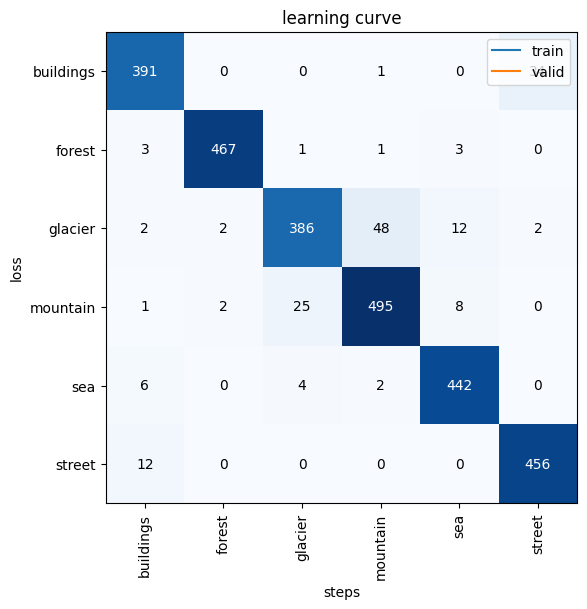

In [22]:
# confusion matrix kaydet
fig = interp.plot_confusion_matrix(figsize=(6,6))
plt.savefig("/kaggle/working/confusion_matrix.png", bbox_inches='tight')

# loss grafiği kaydet
learn.recorder.plot_loss()
plt.savefig("/kaggle/working/loss_curve.png", bbox_inches='tight')

print("Kaydedilenler: export.pkl, resnet18-intel-best.pth, confusion_matrix.png, loss_curve.png")